In [1]:
import jax.numpy as jnp
import jax
jax.config.update("jax_enable_x64", True)

import numpy as np
import scipy
import matplotlib.pyplot as plt

import sys, os

In [2]:
# Set choice of parameters.

gamma_a = 3.5
gamma_b = 0.8
sigma = 3

In [3]:
# Let's first demonstrate a working example in scipy.

In [4]:
def gamma_scipy(x, a, b):
    return b**a / scipy.special.gamma(a) * x**(a-1) * np.exp(-b*x)

def gamma_conv_scipy(x, a, b, sigma=3):
    '''
    Implements convolution of gamma distribution with a normal distribution.
    Such distribution arises from adding gaussian noise to samples from a gamma distribution.
    See eq. 7 of arXiv:0704.1706 [astro-ph].
    '''
    eta = b*sigma - x/sigma
    s_eta_sq = 0.5 * eta**2 # argument to hyp1f1 is always positive.
    
    fac1 = (b**a * sigma **(a-1) * np.exp(-0.5*(x/sigma)**2)) / 2**(0.5*(1+a))
    s1 = scipy.special.hyp1f1(0.5*a, 0.5, s_eta_sq) / scipy.special.gamma(0.5*(a+1))
    s2 = scipy.special.hyp1f1(0.5*(a+1), 3./2., s_eta_sq) / scipy.special.gamma(0.5*a)
    return fac1 * (s1 - np.sqrt(2)*eta*s2)

/tmp/ipykernel_71703/1051358395.py:2: RuntimeWarning: invalid value encountered in power
  return b**a / scipy.special.gamma(a) * x**(a-1) * np.exp(-b*x)


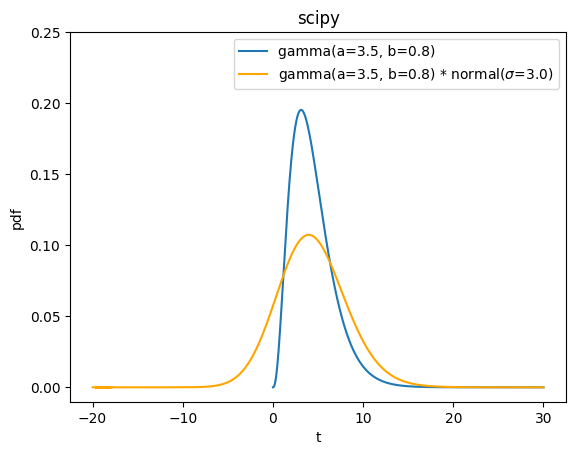

In [5]:
xvals = np.linspace(-20, 30, 10000)
yvals_scipy = gamma_scipy(xvals, gamma_a, gamma_b)
yvals_conv_scipy = gamma_conv_scipy(xvals, gamma_a, gamma_b, sigma=sigma)

fig, ax = plt.subplots()
ax.plot(xvals, yvals_scipy, label=f'gamma(a={gamma_a:.1f}, b={gamma_b:.1f})')
ax.plot(xvals, yvals_conv_scipy, label=f'gamma(a={gamma_a:.1f}, b={gamma_b:.1f}) * normal($\sigma$={sigma:.1f})', color='orange')
ax.set_xlabel('t')
ax.set_ylabel('pdf')
ax.set_ylim(ymax=0.25)
ax.legend()
ax.set_title('scipy')
plt.show()

In [6]:
# Now compare to jax.
# and notice the erratic behavior for t < -5 
# (This is the region where the x-argument of hyp1f1 goes towards 0. X remains positive by construction.)

In [7]:
def gamma_jax(x, a, b):
    return b**a / jax.scipy.special.gamma(a) * x**(a-1) * jnp.exp(-b*x)

@jax.jit
def gamma_conv_jax(x, a, b, sigma=3):
    '''
    Implements convolution of gamma distribution with a normal distribution.
    Such distribution arises from adding gaussian noise to samples from a gamma distribution.
    See eq. 7 of arXiv:0704.1706 [astro-ph].
    '''
    eta = b*sigma - x/sigma
    s_eta_sq = 0.5 * eta**2 # argument to hyp1f1 is always positive.
    
    fac1 = (b**a * sigma **(a-1) * jnp.exp(-0.5*(x/sigma)**2)) / 2**(0.5*(1+a))
    s1 = jax.scipy.special.hyp1f1(0.5*a, 0.5, s_eta_sq) / jax.scipy.special.gamma(0.5*(a+1))
    s2 = jax.scipy.special.hyp1f1(0.5*(a+1), 3./2., s_eta_sq) / jax.scipy.special.gamma(0.5*a)
    return fac1 * (s1 - np.sqrt(2)*eta*s2)

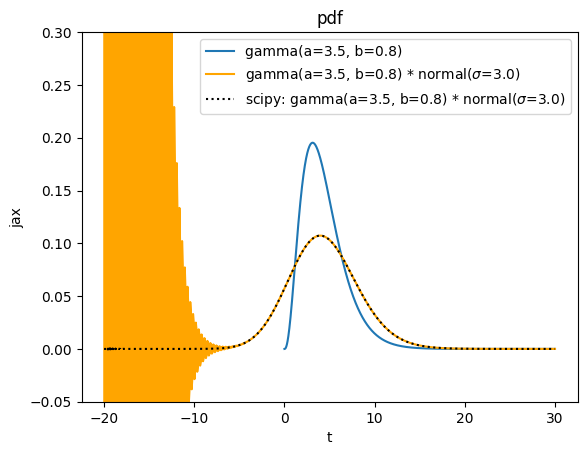

In [8]:
xvals = jnp.linspace(-20, 30, 10000)
yvals_jax = gamma_jax(xvals, gamma_a, gamma_b)
yvals_conv_jax = gamma_conv_jax(xvals, gamma_a, gamma_b, sigma=sigma)

fig, ax = plt.subplots()
ax.plot(xvals, yvals_jax, label=f'gamma(a={gamma_a:.1f}, b={gamma_b:.1f})')
ax.plot(xvals, yvals_conv_jax, 
        label=f'gamma(a={gamma_a:.1f}, b={gamma_b:.1f}) * normal($\sigma$={sigma:.1f})', color='orange')

ax.plot(xvals, yvals_conv_scipy, 
        label=f'scipy: gamma(a={gamma_a:.1f}, b={gamma_b:.1f}) * normal($\sigma$={sigma:.1f})', color='black', 
        linestyle='dotted')

ax.set_xlabel('t')
ax.set_ylabel('jax')
ax.set_ylim([-0.05, 0.3])
ax.legend()
ax.set_title('pdf')
plt.show()

In [9]:
# Let's fix it by increasing the precision in the series expansion of hyp1f1 used by jax.

In [10]:
from jax import lax

def _hyp1f1_serie(a, b, x, tol):
  """
  From https://github.com/google/jax/blob/beaabae8f6d2ceb049840f59c6683e93a67726ae/jax/_src/scipy/special.py#L2408
  Added tolerance argument. jax default corresponds to tol=1.e-8.
  """
    
  def body(state):
    serie, k, term = state
    serie += term
    term *= (a + k) / (b + k) * x / (k + 1)
    k += 1

    return serie, k, term

  def cond(state):
    serie, k, term = state

    return (k < 250) & (lax.abs(term) / lax.abs(serie) > tol)

  init = 1, 1, a / b * x

  return lax.while_loop(cond, body, init)[0]

# vectorize for plotting along x
hyp1f1 = jax.jit(jax.vmap(_hyp1f1_serie, (None, None, 0, None), 0))

In [11]:
# Let's try the convoluted gamma again.

@jax.jit
def gamma_conv_jax_variable_precision(x, a, b, sigma=3, tol=1.e-8):
    '''
    Implements convolution of gamma distribution with a normal distribution.
    Such distribution arises from adding gaussian noise to samples from a gamma distribution.
    See eq. 7 of arXiv:0704.1706 [astro-ph].
    '''
    eta = b*sigma - x/sigma
    s_eta_sq = 0.5 * eta**2
    
    fac1 = (b**a * sigma **(a-1) * jnp.exp(-0.5*(x/sigma)**2)) / 2**(0.5*(1+a))
    s1 = hyp1f1(0.5*a, 0.5, s_eta_sq, tol) / jax.scipy.special.gamma(0.5*(a+1))
    s2 = hyp1f1(0.5*(a+1), 3./2., s_eta_sq, tol) / jax.scipy.special.gamma(0.5*a)
    return fac1 * (s1 - np.sqrt(2)*eta*s2)

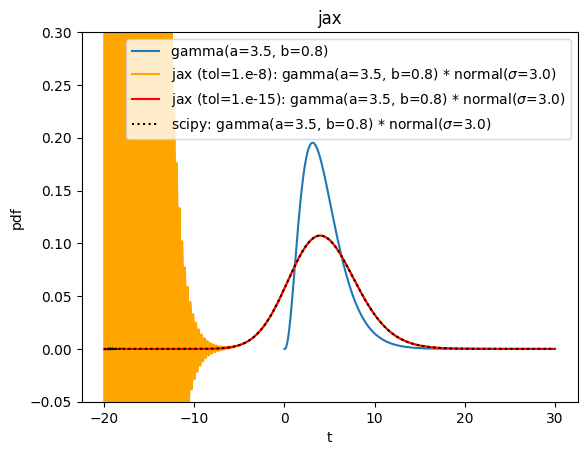

In [12]:
xvals = jnp.linspace(-20, 30, 10000)
yvals_jax = gamma_jax(xvals, gamma_a, gamma_b)
yvals_conv_jax_default = gamma_conv_jax_variable_precision(xvals, gamma_a, gamma_b, sigma=sigma, tol=1.e-8)
yvals_conv_jax = gamma_conv_jax_variable_precision(xvals, gamma_a, gamma_b, sigma=sigma, tol=1.e-15)

fig, ax = plt.subplots()
ax.plot(xvals, yvals_jax, label=f'gamma(a={gamma_a:.1f}, b={gamma_b:.1f})')
ax.plot(xvals, yvals_conv_jax_default, 
        label=f'jax (tol=1.e-8): gamma(a={gamma_a:.1f}, b={gamma_b:.1f}) * normal($\sigma$={sigma:.1f})', color='orange')
ax.plot(xvals, yvals_conv_jax, 
        label=f'jax (tol=1.e-15): gamma(a={gamma_a:.1f}, b={gamma_b:.1f}) * normal($\sigma$={sigma:.1f})', color='red')
ax.plot(xvals, yvals_conv_scipy, 
        label=f'scipy: gamma(a={gamma_a:.1f}, b={gamma_b:.1f}) * normal($\sigma$={sigma:.1f})', color='black', 
        linestyle='dotted')

ax.set_xlabel('t')
ax.set_ylabel('pdf')
ax.set_ylim([-0.05, 0.3])
ax.legend()
ax.set_title('jax')
plt.show()

In [13]:
# And voila. Improved precision (red) resolves the erratic behavior of the default choice in jax (orange).

In [14]:
jax.print_environment_info()

jax:    0.4.28
jaxlib: 0.4.28
numpy:  1.26.4
python: 3.11.5 (main, Sep 22 2023, 17:02:10) [GCC 11.4.0]
jax.devices (2 total, 2 local): [cuda(id=0) cuda(id=1)]
process_count: 1
platform: uname_result(system='Linux', node='hanscomp', release='6.8.0-76060800daily20240311-generic', version='#202403110203~1715181801~22.04~aba43ee SMP PREEMPT_DYNAMIC Wed M', machine='x86_64')


$ nvidia-smi
Wed May 29 16:45:24 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|===========================

In [23]:
x0 = -20
sigma = 3
eta = gamma_b*sigma - x0/sigma
s_eta_sq = 0.5 * eta**2
print(s_eta_sq)

41.10222222222222
